# Loading Data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
False
audio (4, 64000)
f0_confidence (4, 1000)
f0_hz (4, 1000)
loudness_db (4, 1000)


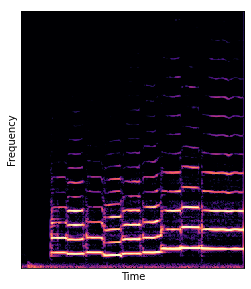

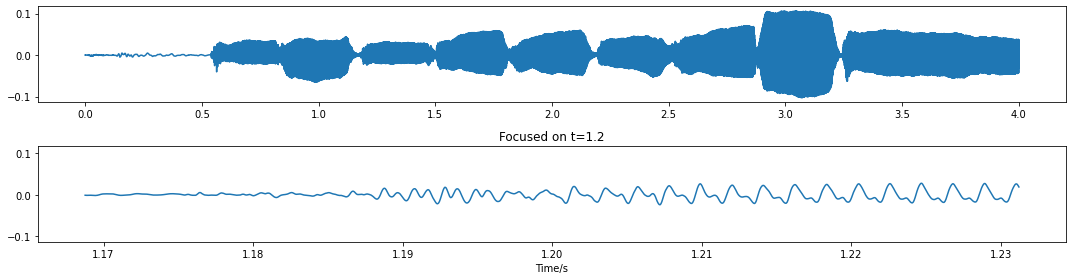

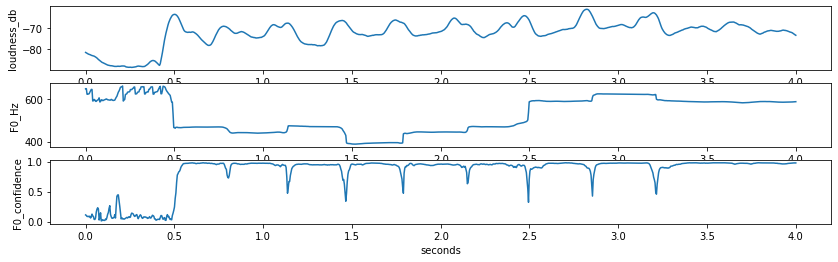

In [5]:
%load_ext autoreload
%autoreload 2

from ddsp.colab import jupyter_utils
import ddsp.training
from matplotlib import pyplot as plt
import numpy as np
import os

TRAIN_TFRECORD_FILEPATTERN = os.environ.get("URMP_MONO")
data_provider = ddsp.training.data.TFRecordProvider(TRAIN_TFRECORD_FILEPATTERN)
print(data_provider is ddsp.training.data.DataProvider)
dataset = data_provider.get_batch(4)

for i in iter(dataset):
    for k, v in i.items():
        print(k, v.shape)
    break

try:
    ex = next(iter(dataset))
except StopIteration:
    raise ValueError(
      'TFRecord contains no examples. Please try re-running the pipeline with '
      'different audio file(s).')

ex = next(iter(dataset))
jupyter_utils.show_audio(ex['audio'][0])

f, ax = plt.subplots(3, 1, figsize=(14, 4))
x = np.linspace(0, 4.0, 1000)
ax[0].set_ylabel('loudness_db')
ax[0].plot(x, ex['loudness_db'][0])
ax[1].set_ylabel('F0_Hz')
ax[1].set_xlabel('seconds')

ax[1].plot(x, ex['f0_hz'][0])
ax[2].set_ylabel('F0_confidence')
ax[2].set_xlabel('seconds')
ax[2].plot(x, ex['f0_confidence'][0])

# Init Model

In [6]:
%reload_ext tensorboard
import tensorboard as tb
import warnings
warnings.filterwarnings("ignore")

import time

import ddsp
from ddsp.training import (data, decoders, encoders, models, preprocessing, 
                           train_util, trainers, discriminator)
import gin
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds


SAVE_DIR = "artifacts/tmp"

# tb.notebook.start('--logdir "{}"'.format(SAVE_DIR))

sample_rate = 16000
n_samples = 4*sample_rate

strategy = train_util.get_strategy()

with strategy.scope():
    TIME_STEPS = 1000

    # Create Neural Networks.
    preprocessor = preprocessing.F0LoudnessPreprocessor(time_steps=TIME_STEPS)

    decoder = decoders.RnnFcDecoder(rnn_channels = 256,
                                    rnn_type = 'gru',
                                    ch = 256,
                                    layers_per_stack = 1,
                                    input_keys = ('ld_scaled', 'f0_scaled', 'z'),
                                    output_splits = (('amps', 1),
                                                    ('harmonic_distribution', 45),
                                                    ('noise_magnitudes', 45)))

    # Create Processors.
    harmonic = ddsp.synths.Harmonic(n_samples=n_samples, 
                                    sample_rate=sample_rate,
                                    name='harmonic')

    noise = ddsp.synths.FilteredNoise(window_size=0,
                                    initial_bias=-10.0,
                                    name='noise')
    add = ddsp.processors.Add(name='add')

    # Create ProcessorGroup.
    dag = [(harmonic, ['amps', 'harmonic_distribution', 'f0_hz']),
        (noise, ['noise_magnitudes']),
        (add, ['noise/signal', 'harmonic/signal'])]

    processor_group = ddsp.processors.ProcessorGroup(dag=dag,
                                                    name='processor_group')


    # Loss_functions
    spectral_loss = ddsp.losses.SpectralLoss(loss_type='L1',
                                            mag_weight=1.0,
                                            logmag_weight=1.0)
    
    encoder = encoders.MfccTimeConstantRnnEncoder(rnn_channels = 512, rnn_type = 'gru', z_dims = 16, z_time_steps = 125)
    
    critic = discriminator.ParallelWaveGANDiscriminator(input_keys=['discriminator_audio', 'f0_hz', 'loudness_db'])
    model = models.Autoencoder(preprocessor=preprocessor,
                                encoder=encoder,
                                decoder=decoder,
                                processor_group=processor_group,
                                discriminator=critic,
                                losses=[spectral_loss])
    trainer = trainers.Trainer(model, strategy, learning_rate=1e-3)
    dataset = trainer.distribute_dataset(dataset)
    trainer.build(next(iter(dataset)))
    dataset_iter = iter(dataset)
    
    for i in range(3000):
        losses = trainer.train_step(dataset_iter)
        res_str = 'step: {}\t'.format(i)
        for k, v in losses.items():
            res_str += '{}: {:.2f}\t'.format(k, v)
        print(res_str)

        if i % 300 == 1:
            print(f"Step {i}")
            trainer.save(SAVE_DIR)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
f0_loudness_preprocessor (F0 multiple                  0         
_________________________________________________________________
mfcc_time_constant_rnn_encod multiple                  844365    
_________________________________________________________________
rnn_fc_decoder (RnnFcDecoder multiple                  1081179   
_________________________________________________________________
processor_group (ProcessorGr multiple                  0         
_________________________________________________________________
spectral_loss (SpectralLoss) multiple                  0         
_________________________________________________________________
parallel_wave_gan_discrimina multiple                  199690    
Total params: 2,125,234
Trainable params: 2,025,769
Non-trainable params: 99,465
________________________________________

INFO:tensorflow:batch_all_reduce: 29 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 29 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 29 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


step: 0	spectral_loss: 47.70	adversarial_loss: 0.07	total_loss: 47.77	discriminator_loss: 0.05	mean_pred_real: 1.00	mean_pred_synth: nan	
step: 1	spectral_loss: 44.98	adversarial_loss: 0.00	total_loss: 44.98	discriminator_loss: 0.75	mean_pred_real: nan	mean_pred_synth: 1.00	
Step 1
step: 2	spectral_loss: 48.17	adversarial_loss: 0.50	total_loss: 48.67	discriminator_loss: 0.00	mean_pred_real: nan	mean_pred_synth: nan	
step: 3	spectral_loss: 47.13	adversarial_loss: 0.50	total_loss: 47.63	discriminator_loss: 0.25	mean_pred_real: nan	mean_pred_synth: 0.50	
step: 4	spectral_loss: 55.37	adversarial_loss: 0.50	total_loss: 55.87	discriminator_loss: 0.50	mean_pred_real: 0.50	mean_pred_synth: 0.50	
step: 5	spectral_loss: 42.26	adversarial_loss: 0.50	total_loss: 42.76	discriminator_loss: 0.25	mean_pred_real: 0.50	mean_pred_synth: nan	
step: 6	spectral_loss: 46.74	adversarial_loss: 0.50	total_loss: 47.24	discriminator_loss: 0.75	mean_pred_real: 0.50	mean_pred_synth: nan	
step: 7	spectral_loss: 41.8

step: 59	spectral_loss: 40.80	adversarial_loss: 0.50	total_loss: 41.30	discriminator_loss: 0.75	mean_pred_real: 0.50	mean_pred_synth: nan	
step: 60	spectral_loss: 33.09	adversarial_loss: 0.50	total_loss: 33.59	discriminator_loss: 0.75	mean_pred_real: 0.50	mean_pred_synth: nan	
step: 61	spectral_loss: 37.46	adversarial_loss: 0.50	total_loss: 37.96	discriminator_loss: 0.75	mean_pred_real: 0.50	mean_pred_synth: nan	
step: 62	spectral_loss: 43.76	adversarial_loss: 0.50	total_loss: 44.26	discriminator_loss: 0.00	mean_pred_real: nan	mean_pred_synth: nan	
step: 63	spectral_loss: 45.00	adversarial_loss: 0.50	total_loss: 45.50	discriminator_loss: 0.50	mean_pred_real: nan	mean_pred_synth: 0.50	
step: 64	spectral_loss: 40.10	adversarial_loss: 0.50	total_loss: 40.60	discriminator_loss: 0.25	mean_pred_real: 0.50	mean_pred_synth: nan	
step: 65	spectral_loss: 36.80	adversarial_loss: 0.50	total_loss: 37.30	discriminator_loss: 0.50	mean_pred_real: 0.50	mean_pred_synth: 0.50	
step: 66	spectral_loss: 33.

step: 118	spectral_loss: 39.17	adversarial_loss: 0.50	total_loss: 39.67	discriminator_loss: 0.75	mean_pred_real: 0.50	mean_pred_synth: nan	
step: 119	spectral_loss: 43.49	adversarial_loss: 0.50	total_loss: 43.99	discriminator_loss: 0.75	mean_pred_real: 0.50	mean_pred_synth: nan	
step: 120	spectral_loss: 34.37	adversarial_loss: 0.50	total_loss: 34.87	discriminator_loss: 0.25	mean_pred_real: nan	mean_pred_synth: 0.50	
step: 121	spectral_loss: 37.99	adversarial_loss: 0.50	total_loss: 38.49	discriminator_loss: 0.25	mean_pred_real: nan	mean_pred_synth: 0.50	
step: 122	spectral_loss: 43.68	adversarial_loss: 0.50	total_loss: 44.18	discriminator_loss: 0.25	mean_pred_real: 0.50	mean_pred_synth: nan	
step: 123	spectral_loss: 41.87	adversarial_loss: 0.50	total_loss: 42.37	discriminator_loss: 0.50	mean_pred_real: 0.50	mean_pred_synth: 0.50	
step: 124	spectral_loss: 38.57	adversarial_loss: 0.50	total_loss: 39.07	discriminator_loss: 0.75	mean_pred_real: nan	mean_pred_synth: 0.50	
step: 125	spectral_

step: 177	spectral_loss: 33.68	adversarial_loss: 0.50	total_loss: 34.18	discriminator_loss: 0.50	mean_pred_real: 0.50	mean_pred_synth: 0.50	
step: 178	spectral_loss: 37.34	adversarial_loss: 0.50	total_loss: 37.84	discriminator_loss: 0.50	mean_pred_real: 0.50	mean_pred_synth: 0.50	
step: 179	spectral_loss: 41.10	adversarial_loss: 0.50	total_loss: 41.60	discriminator_loss: 0.75	mean_pred_real: 0.50	mean_pred_synth: nan	
step: 180	spectral_loss: 32.22	adversarial_loss: 0.50	total_loss: 32.72	discriminator_loss: 0.50	mean_pred_real: 0.50	mean_pred_synth: 0.50	
step: 181	spectral_loss: 38.76	adversarial_loss: 0.50	total_loss: 39.26	discriminator_loss: 0.50	mean_pred_real: 0.50	mean_pred_synth: 0.50	
step: 182	spectral_loss: 39.00	adversarial_loss: 0.50	total_loss: 39.50	discriminator_loss: 0.25	mean_pred_real: 0.50	mean_pred_synth: nan	
step: 183	spectral_loss: 43.96	adversarial_loss: 0.50	total_loss: 44.46	discriminator_loss: 0.75	mean_pred_real: nan	mean_pred_synth: 0.50	
step: 184	spectr

step: 236	spectral_loss: 36.17	adversarial_loss: 0.50	total_loss: 36.67	discriminator_loss: 1.00	mean_pred_real: nan	mean_pred_synth: nan	
step: 237	spectral_loss: 34.61	adversarial_loss: 0.50	total_loss: 35.11	discriminator_loss: 0.75	mean_pred_real: nan	mean_pred_synth: 0.50	
step: 238	spectral_loss: 34.83	adversarial_loss: 0.50	total_loss: 35.33	discriminator_loss: 0.75	mean_pred_real: nan	mean_pred_synth: 0.50	
step: 239	spectral_loss: 50.60	adversarial_loss: 0.50	total_loss: 51.10	discriminator_loss: 0.50	mean_pred_real: 0.50	mean_pred_synth: 0.50	
step: 240	spectral_loss: 32.75	adversarial_loss: 0.50	total_loss: 33.25	discriminator_loss: 0.75	mean_pred_real: nan	mean_pred_synth: 0.50	
step: 241	spectral_loss: 41.40	adversarial_loss: 0.50	total_loss: 41.90	discriminator_loss: 0.50	mean_pred_real: nan	mean_pred_synth: 0.50	
step: 242	spectral_loss: 37.41	adversarial_loss: 0.50	total_loss: 37.91	discriminator_loss: 1.00	mean_pred_real: nan	mean_pred_synth: nan	
step: 243	spectral_lo

step: 295	spectral_loss: 32.92	adversarial_loss: 0.50	total_loss: 33.42	discriminator_loss: 0.25	mean_pred_real: nan	mean_pred_synth: 0.50	
step: 296	spectral_loss: 36.85	adversarial_loss: 0.50	total_loss: 37.35	discriminator_loss: 0.50	mean_pred_real: 0.50	mean_pred_synth: 0.50	
step: 297	spectral_loss: 37.87	adversarial_loss: 0.50	total_loss: 38.37	discriminator_loss: 0.50	mean_pred_real: 0.50	mean_pred_synth: 0.50	
step: 298	spectral_loss: 35.54	adversarial_loss: 0.50	total_loss: 36.04	discriminator_loss: 0.25	mean_pred_real: nan	mean_pred_synth: 0.50	
step: 299	spectral_loss: 39.19	adversarial_loss: 0.50	total_loss: 39.69	discriminator_loss: 0.75	mean_pred_real: nan	mean_pred_synth: 0.50	
step: 300	spectral_loss: 37.40	adversarial_loss: 0.50	total_loss: 37.90	discriminator_loss: 0.50	mean_pred_real: 0.50	mean_pred_synth: 0.50	
step: 301	spectral_loss: 39.89	adversarial_loss: 0.50	total_loss: 40.39	discriminator_loss: 0.25	mean_pred_real: 0.50	mean_pred_synth: nan	
Step 301
step: 30

KeyboardInterrupt: 